In [2]:
import os
from ast import literal_eval

import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

import fastestimator as fe
from fastestimator.architecture.retinanet import RetinaNet, get_fpn_anchor_box, get_target
from fastestimator.op import NumpyOp
from fastestimator.op.numpyop import ImageReader, ResizeImageAndBbox, TypeConverter
from fastestimator.op.tensorop import Loss, ModelOp, Pad, Rescale

## Utilities

In [3]:
class String2List(NumpyOp):
    # this thing converts '[1, 2, 3]' into np.array([1, 2, 3])
    def forward(self, data, state):
        data = map(literal_eval, data)
        return data

In [4]:
class GenerateTarget(NumpyOp):
    def __init__(self, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.anchorbox, _ = get_fpn_anchor_box(input_shape=(512, 512, 3))

    def forward(self, data, state):
        obj_label, x1, y1, width, height = data
        cls_gt, x1_gt, y1_gt, w_gt, h_gt = get_target(self.anchorbox, obj_label, x1, y1, width, height)
        return cls_gt, x1_gt, y1_gt, w_gt, h_gt

In [5]:
all_anchors, num_anchors_per_level = get_fpn_anchor_box((512, 512, 3))

In [6]:
assert all_anchors.shape == (49104, 4)

In [7]:
assert all_anchors.shape[0] == num_anchors_per_level.sum()

## Original data

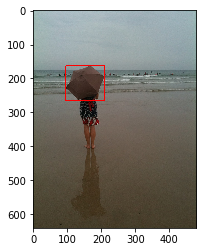

In [51]:
im = cv2.imread('/data/hsiming/dataset/MSCOCO2017/train2017/000000532867.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots()

x1 = 96
y1 = 163
w = 113
h = 102

cv2.rectangle(im, (x1, y1), (x1+w, y1+h), (255, 0, 0), 2)
    
ax.imshow(im)

## Pipeline

In [9]:
train_csv = '/data/hsiming/dataset/MSCOCO2017/train_object.csv'
val_csv = '/data/hsiming/dataset/MSCOCO2017/val_object.csv'
path = '/data/hsiming/dataset/MSCOCO2017/'

In [10]:
writer = fe.RecordWriter(
    save_dir=os.path.join(path, "retinanet_coco"),
    train_data=train_csv,
    validation_data=val_csv,
    ops=[
        ImageReader(inputs="image", parent_path=path, outputs="image"),
        String2List(inputs=["x1", "y1", "width", "height", "obj_label"],
                    outputs=["x1", "y1", "width", "height", "obj_label"]),
        ResizeImageAndBbox(target_size=(512, 512),
                           keep_ratio=True,
                           inputs=["image", "x1", "y1", "width", "height"],
                           outputs=["image", "x1", "y1", "width", "height"]),
        GenerateTarget(inputs=("obj_label", "x1", "y1", "width", "height"),
                       outputs=("cls_gt", "x1_gt", "y1_gt", "w_gt", "h_gt")),
        TypeConverter(target_type='int32', inputs=["id", "cls_gt"], outputs=["id", "cls_gt"]),
        TypeConverter(target_type='float32',
                      inputs=["x1_gt", "y1_gt", "w_gt", "h_gt"],
                      outputs=["x1_gt", "y1_gt", "w_gt", "h_gt"])
    ],
    compression="GZIP",
    write_feature=["image", "id", "cls_gt", "x1_gt", "y1_gt", "w_gt", "h_gt"])

In [11]:
# prepare pipeline
pipeline = fe.Pipeline(
    batch_size=8,
    data=writer,
    ops=[
        Rescale(inputs="image", outputs="image"),
        Pad(padded_shape=[190], inputs=["x1_gt", "y1_gt", "w_gt", "h_gt"], outputs=["x1_gt", "y1_gt", "w_gt", "h_gt"])
    ])

In [105]:
batch_data = pipeline.show_results(mode='train', num_steps=1)

FastEstimator: Reading non-empty directory: /data/hsiming/dataset/MSCOCO2017/retinanet_coco
FastEstimator: Found 117266 examples for train in /data/hsiming/dataset/MSCOCO2017/retinanet_coco/train_summary0.json
FastEstimator: Found 4952 examples for eval in /data/hsiming/dataset/MSCOCO2017/retinanet_coco/eval_summary0.json


In [106]:
batch_data[0].keys()

dict_keys(['y1_gt', 'h_gt', 'w_gt', 'cls_gt', 'id', 'image', 'x1_gt'])

In [107]:
batch_data[0]['image'].shape

TensorShape([8, 512, 512, 3])

id = 372199


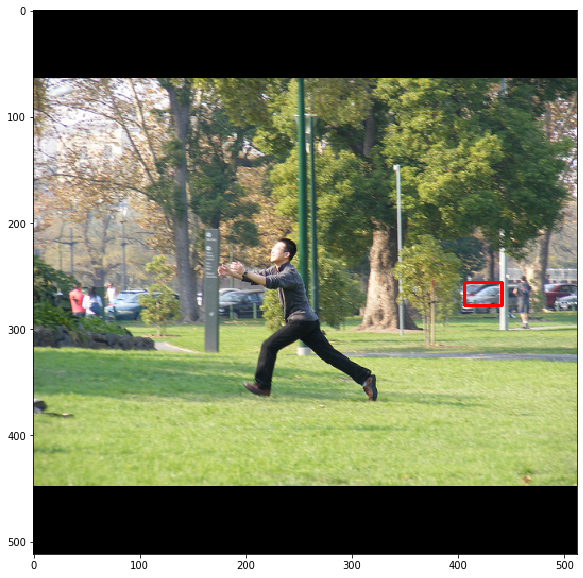

In [167]:
index = 6
img = batch_data[0]['image'].numpy()[index]
img = ((img + 1) / 2 * 255).astype(np.uint8)

x1 = 406
y1 = 256
w = 35
h = 22


cv2.rectangle(img, (x1, y1), (x1 + w, y1 + h), (255, 0, 0), 2)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

print("id = {}".format(batch_data[0]['id'].numpy()[index]))

In [118]:
gt_cls = batch_data[0]['cls_gt'].numpy()[index]

In [119]:
class_args = np.argwhere(gt_cls > 0)

In [120]:
class_args

array([[19573],
       [41492],
       [41495],
       [41498],
       [41508],
       [41510],
       [41511],
       [41513],
       [41710],
       [41713],
       [41790],
       [41792],
       [41793],
       [41795],
       [41811],
       [41812],
       [41875],
       [42020],
       [47241],
       [47250],
       [47251],
       [47253],
       [47254],
       [47277],
       [47278],
       [47280],
       [47281],
       [47349],
       [47350],
       [47352],
       [47353],
       [47355],
       [47356],
       [47360],
       [47363],
       [47367],
       [48707]])

In [121]:
gt_cls[class_args]

array([[3],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [3],
       [3],
       [1],
       [1],
       [1],
       [1],
       [3],
       [3],
       [3],
       [1],
       [1],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [1],
       [1],
       [3],
       [1]], dtype=int32)

In [44]:
selected_anchors = all_anchors[class_args]

In [54]:
selected_anchors.shape

(13, 1, 4)

In [45]:
selected_anchors

array([[[ 96.      , 144.      ,   8.      ,   8.      ]],

       [[102.34315 , 145.17157 ,  11.313708,   5.656854]],

       [[136.      , 144.      ,   8.      ,   8.      ]],

       [[137.17157 , 142.34314 ,   5.656854,  11.313708]],

       [[144.      , 144.      ,   8.      ,   8.      ]],

       [[232.      , 144.      ,   8.      ,   8.      ]],

       [[241.17157 , 142.34314 ,   5.656854,  11.313708]],

       [[248.      , 144.      ,   8.      ,   8.      ]],

       [[296.      , 144.      ,   8.      ,   8.      ]],

       [[302.34314 , 145.17157 ,  11.313708,   5.656854]],

       [[318.96033 , 142.96031 ,  10.079369,  10.079369]],

       [[190.0406  , 204.0812  ,  35.918785,  71.83757 ]],

       [[ 88.16243 , 124.081215, 143.67514 ,  71.83757 ]]], dtype=float32)

In [63]:
x1 = batch_data[0]['x1_gt'].numpy()[index]
y1 = batch_data[0]['y1_gt'].numpy()[index]
w = batch_data[0]['w_gt'].numpy()[index]
h = batch_data[0]['h_gt'].numpy()[index]

In [64]:
x1

array([ 0.125     , -0.03033022,  0.        ,  0.32322386,  0.75      ,
        0.125     ,  0.14644715,  0.25      ,  0.        ,  0.67677724,
        0.698424  , -0.44657978,  0.36079708,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [65]:
(x1[12] * selected_anchors[-1, 0, 2]) + selected_anchors[-1, 0, 0]

140.0

In [66]:
(y1[12] * selected_anchors[-1, 0, 3]) + selected_anchors[-1, 0, 1]

130.0

In [67]:
np.exp(w[12]) * selected_anchors[-1, 0, 2]

90.0

In [68]:
np.exp(h[12]) * selected_anchors[-1, 0, 3]

81.0

## Model inference

In [42]:
trained_model = load_model('/data/hsiming/dev/retinanet_best_total_loss.h5', compile=False)

In [153]:
cls, delta = trained_model(batch_data[0]['image'][index:index+1])
cls = np.squeeze(cls.numpy())
delta = np.squeeze(delta.numpy())

In [195]:
cls_pred = np.argmax(cls, axis=1)
score = np.max(cls, axis=1)

In [198]:
delta.shape

(49104, 4)

In [203]:
delta[[0, 2, 2], :][2, :]

array([ 0.12265791,  0.19722751, -0.22025388, -0.33690053], dtype=float32)

In [197]:
score.shape

(49104,)

### Loop through level

In [196]:
num_anchors_per_level

array([36864,  9216,  2304,   576,   144], dtype=int32)

In [243]:
end_index = 0

selected_delta = []
selected_score = []
selected_cls = []
selected_anchor_indices = []

# loop through each pyramid level
for i in range(len(num_anchors_per_level)):
    start_index = end_index
    end_index += num_anchors_per_level[i]
    
    anchor_indices = np.arange(start_index, end_index)
    level_score = score[anchor_indices]
    
    # select top 1k
    if num_anchors_per_level[i] >= 1000:
        topk_indices = np.argsort(-level_score)[0:1000]  # negative sign for descending order
    else:
        topk_indices = np.array(range(len(level_score)))
        
    # filter out low score
    is_high_score = level_score[topk_indices] > 0.05
    selected_indices = topk_indices[is_high_score]
    
    selected_score.append(level_score[selected_indices])
    
    selected_delta.append(delta[anchor_indices, :][selected_indices, :])
    selected_cls.append(cls_pred[anchor_indices][selected_indices])
    selected_anchor_indices.append(anchor_indices[selected_indices])

In [244]:
selected_score = np.concatenate(selected_score, axis=0)
selected_delta = np.concatenate(selected_delta, axis=0)
selected_cls = np.concatenate(selected_cls, axis=0)
selected_anchor_indices = np.concatenate(selected_anchor_indices, axis=0)

In [249]:
descend = np.argsort(-selected_score)

In [251]:
selected_score = selected_score[descend]
selected_delta = selected_delta[descend, :]
selected_cls = selected_cls[descend]
selected_anchor_indices = selected_anchor_indices[descend]

In [252]:
selected_score.shape

(1128,)

In [253]:
selected_delta.shape

(1128, 4)

In [254]:
selected_cls.shape

(1128,)

In [255]:
selected_anchor_indices.shape

(1128,)

In [256]:
selected_score

array([0.6604739 , 0.56569064, 0.5529922 , ..., 0.05013323, 0.05008066,
       0.05002952], dtype=float32)

### Apply deltas

id = 372199


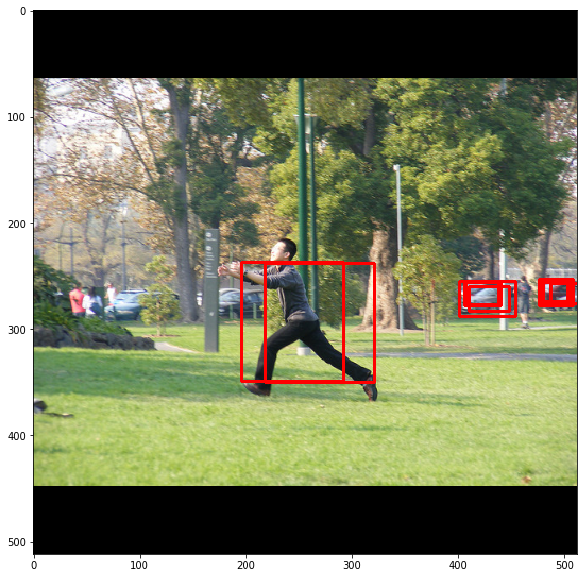

In [277]:
img = batch_data[0]['image'].numpy()[index]
img = ((img + 1) / 2 * 255).astype(np.uint8)


for i in range(10):
    cv2.rectangle(img, (x1[i], y1[i]), (x2[i], y2[i]), (255, 0, 0), 2)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

print("id = {}".format(batch_data[0]['id'].numpy()[index]))

In [158]:
delta[select]

array([ 0.00415737,  0.08388364, -0.0320079 ,  0.21840556], dtype=float32)

In [159]:
all_anchors[select]

array([406.04062 , 255.02031 ,  35.918785,  17.959393], dtype=float32)

In [265]:
x1 = (selected_delta[:, 0] * all_anchors[selected_anchor_indices][:, 2]) + all_anchors[selected_anchor_indices][:, 0]

In [266]:
x1.shape

(1128,)

In [267]:
y1 = (selected_delta[:, 1] * all_anchors[selected_anchor_indices][:, 3]) + all_anchors[selected_anchor_indices][:, 1]

In [268]:
w = np.exp(selected_delta[:, 2]) * all_anchors[selected_anchor_indices][:, 2]

In [269]:
h = np.exp(selected_delta[:, 3]) * all_anchors[selected_anchor_indices][:, 3]

In [270]:
x2 = x1 + w

In [271]:
y2 = y1 + h